# *Data Exploration*

<p style='text-align: justify;'>This notebook serves as a summary of my data exploration journey. The purpose of this notebook is to give readers an understanding of the dataset characteristic and appreciate the analytical steps, necessary in any Deep Learning (DL) project. The outcome of this analysis will impact the performance of the DL project and is the most time consuming. The project can be broken down into the following sections:</p>

__1.  Analyze the Dataset__

    1.1 Load the necessary supporting and custom libraries into workspace
    1.2 Some debug flags
    1.3 Locate the Datasets (Training + Test) and Labels
    1.4 Exploiting Bonus information	

__2.  Peek into the Dataset (Training + Test)__
    
    2.1 Data Visualization
        2.1.1 Images with Ships
        2.1.2 Images without Ships
    2.2 Dataset Information
        2.2.1 Training Dataset
        2.2.2 Test Dataset
    2.3 Image Pixel density of Ship Images
    2.4 Quick Analysis and Recommendation
        2.4.1 Determine Number of Valid Images with mask
        2.4.2 Image Generation by RandomRotation
         
__3.  Visualize Ship Images with Mask Information and Bounding Box__
  
__4.  Identify and Export test Parameters for use by Deep Learning Algorithm for Image Segmentation__
    
    2.1 Create Dictionary of Bounding Boxes w.r.t. Images - for DL algorithm use
    2.2 Export the information
    2.3 (Optional) View of Information exported

# 1.   Analyze the Dataset

## 1.1   Load the necessary supporting and custom libraries into workspace

In [1]:
import os
import cv2
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util import montage2d as montage
import preprocess_lib_clean as prelib  # Load Custom Library
from skimage.morphology import label
from torch.utils import data as utils_data
import torchvision.transforms as transforms
import os.path as osp
import glob
import random
from PIL import Image
import gc

# For Training
import torchvision
import torch.nn as nn
from models import *

## 1.2   Some debug flags

In [2]:
double_check = 1
data_generation = 0

## 1.3   Locate the Datasets (Training + Test) and Labels

In [3]:
# Common path variables
train_path = '../train/'
test_path = '../test/'
train_label_path = '../input/train_ship_segmentations.csv'
test_label_path = '../input/test_ship_segmentations.csv'

## 1.4   Exploiting Bonus information

Upon loading of the labels, you will immediately notice it contains 2 columns of data - ImageID and EncodedPixels.

In [4]:
masks_data = prelib.LoadMyData(train_label_path, pandas=True)
print('Total Number of images found --> ' + str(masks_data['ImageId'].value_counts().shape[0]))
masks_data.head(5)

Total Number of images found --> 104070


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


<p style='text-align: justify;'>Occasionally, the EncodedPixel column may contain NaN value, which means no ship present for the corresponding ImageID. It is from this information, we are able to infer two information from this dataset - IsShipPresent and TotalNumberofShips - for every image. The next step will perform this data aggregation and inferrence. In addition, NULL values are observed and it serves to inform that no ship is detected in the image. The next step will be to better understand the number and distribution of the Ships per picture, within our dataset.</p>

 ***

In [5]:
trainlabel_load_ship = prelib.load_file("train")
testlabel_load_ship = prelib.load_file("test")
trainlabel_load_ship.head(5)

,HasShip,TotalShips
ImageId,,
00003e153.jpg,False,0.0
000155de5.jpg,True,1.0
00021ddc3.jpg,True,9.0
0002756f7.jpg,True,2.0
0002d0f32.jpg,False,0.0


***
*__Additional Information on EncodedPixels:__*

<p style='text-align: justify;'>The information above is encoded in run-length-encoding format and it appears to be the standard used in Kaggle competition. As such, existing implementations to decode or encode RLE are readily available. From the RLE information, we are able to transform the encoded information to derive the contents of each ImageID such as informing us if a ship is present in the picture. If a ship is present,then provide the pixel coordinates which outlines the ship's image location. It is usually safe to assume that the ImageID and RLE Encoded pixel information is always in pairs. Every time you find a set of two numbers (eg. 369226 3), you get the first pixel as a index and the next number is the length of pixels until find a background. For example,</p>

- __264661 17__ => 17 pixels starting from 264661 and ending on 264678.
- __265429 33__ => 33 pixels starting from 265429 and ending on 265462. And so on.

<p style='text-align: justify;'>We can trivially encode and decode from a start scalar position like 264661 into a 2-d coordinate, given 768x768 picture, using the % and $//$ and $*$ operators. For example, an example code snippet is: <font color = purple> 2dcoordinate = (start % 768, start // 768) </font>. For convenience, the relevant RLE functions have been incorporated into our custom library and is used in this notebook.</p>

For further reading on RLE, I would refer readers to existing tutorials by __[Paulorzp](https://www.kaggle.com/paulorzp/run-length-encode-and-decode)__ and __[Inversion](https://www.kaggle.com/inversion/run-length-decoding-quick-start)__.
***

# 2. Peek into the Dataset (Training + Test)

## 2.1   Visualizing the images

### 2.1.1   Images with Ships

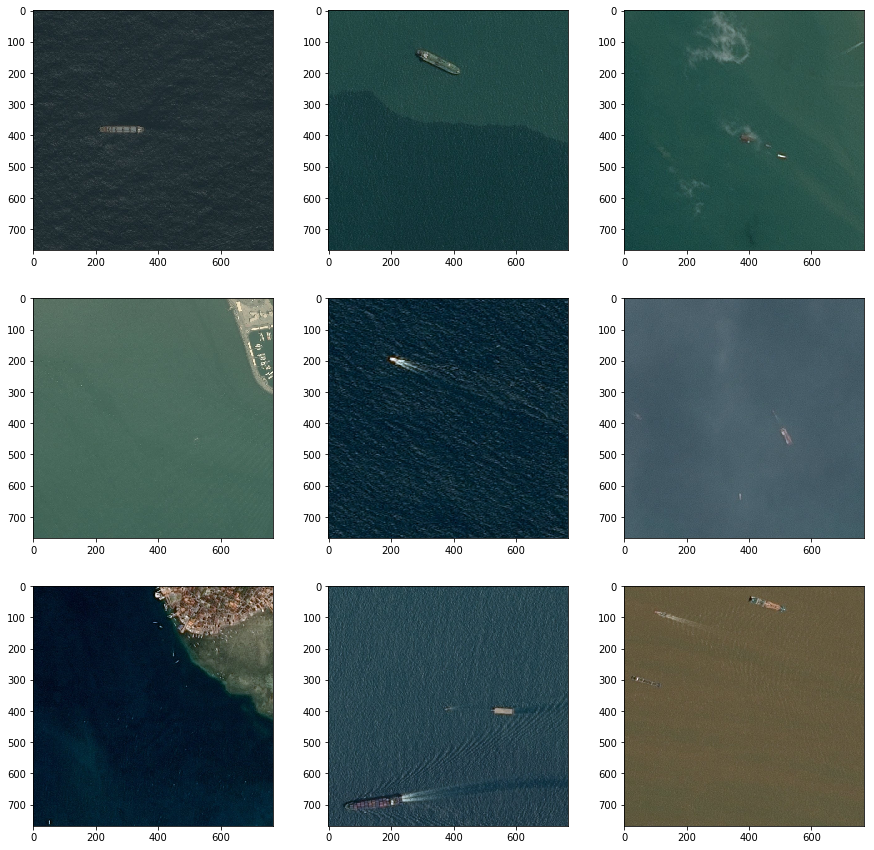

In [20]:
train_sample = masks_data[~masks_data.EncodedPixels.isna()].sample(9)
#randomly choose 9 pics from train images with ships
fig, axes = plt.subplots(3, 3, figsize=(15,15))
for i, image_id in enumerate(train_sample.ImageId):
    col = i % 3
    row = i // 3
    img = imread(f'../train/{image_id}')
    axes[row, col].axis('on')
    axes[row, col].imshow(img)

### 2.1.2   Images without Ships

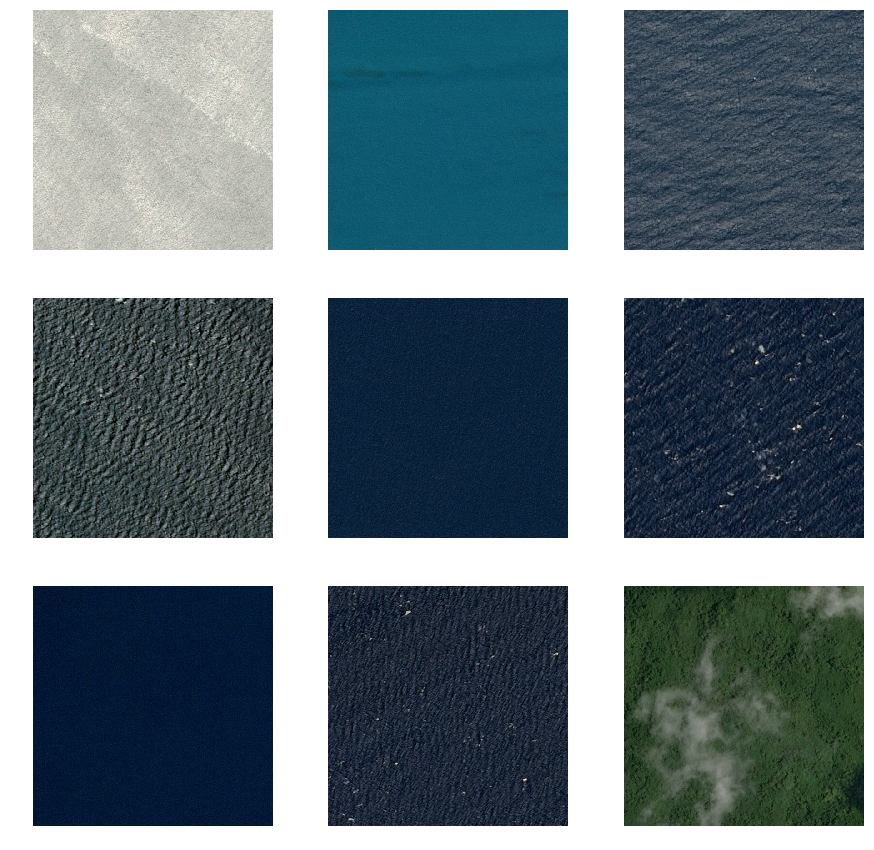

In [7]:
train_sample_noships = masks_data[masks_data.EncodedPixels.isna()].sample(9)
#randomly choose 9 pics from train images without ships
fig, axes = plt.subplots(3, 3, figsize=(15,15))
for i, image_id in enumerate(train_sample_noships.ImageId):
    col = i % 3
    row = i // 3
    img = imread(f'../train/{image_id}')
    axes[row, col].axis('off')
    axes[row, col].imshow(img)

## 2.2   Dataset Information


### 2.2.1 Training Dataset

------------------------------------ 
----- Training Set Data ------------ 
------------------------------------ 
 ------ Additional Info ------
Images Found: 104070
Images with ships:    0.28 (29070)
Images with no ships: 0.72 (75000)
Total Number of Ships Present:  56030
Mean number of Ships per image with Ship: 1.9274165806673547
Standard Deviation on Ships per image with Ship: 1.9309598753704391


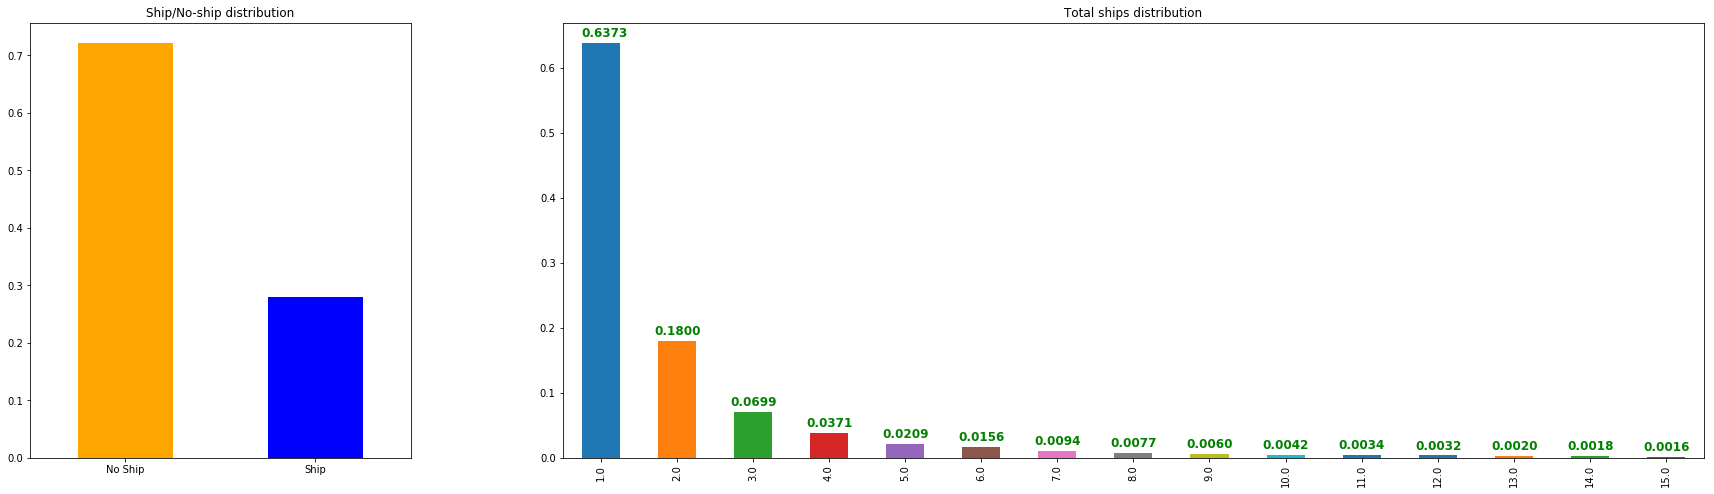

In [8]:
# Input: Training label dataset
print('------------------------------------ ')
print('----- Training Set Data ------------ ')
print('------------------------------------ ')
# print('-- Overview of TotalShips Column --- ')
# print(trainlabel_load_ship['TotalShips'].describe())
# print('')
# print('------------------------------------ ')
prelib.show_data_distrib(trainlabel_load_ship)  # Training Data

### 2.2.2   Test Dataset

-------------------------------- 
-------- Test Set Data --------- 
-------------------------------- 
 ------ Additional Info ------
Images Found: 88486
Images with ships:    0.15 (13486)
Images with no ships: 0.85 (75000)
Total Number of Ships Present:  25693
Mean number of Ships per image with Ship: 1.9051609076078897
Standard Deviation on Ships per image with Ship: 1.851268007877711


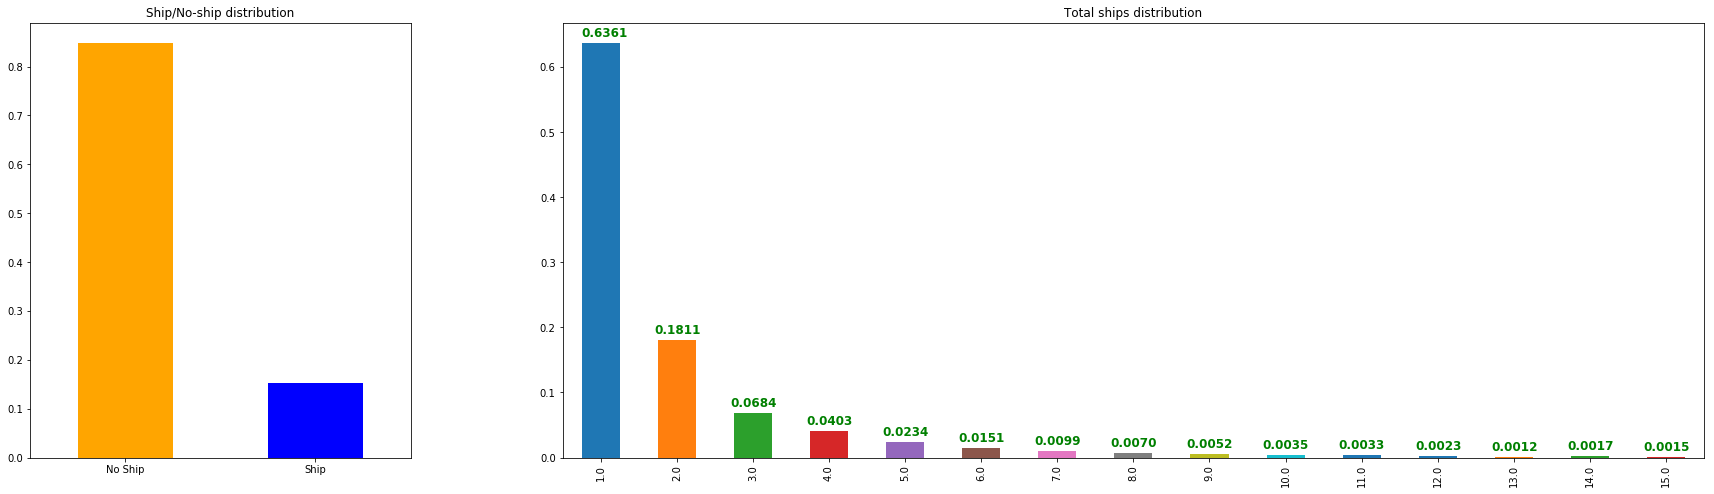

In [9]:
print('-------------------------------- ')
print('-------- Test Set Data --------- ')
print('-------------------------------- ')
# print(testlabel_load_ship['TotalShips'].describe())
# print('')
# print('-------------------------------- ')
prelib.show_data_distrib(testlabel_load_ship)  # Test Data

## 2.3   Image Pixel density of Ship Images

From the information below, the challenge for ship detection becomes obvious. When armed with such information on the dataset, the team can further decide on the necessary optimizations and modifications needed to improve the performance of the DL algorithm. 

In [10]:
pixel_density = pd.read_csv(train_label_path).append(pd.read_csv(test_label_path))
hasship, noship = prelib.get_pixels_distribution(pixel_density.dropna())  # Distribution after removing noship images

Ship: 0.005 (128092863)
No ship: 0.995 (24972457281)


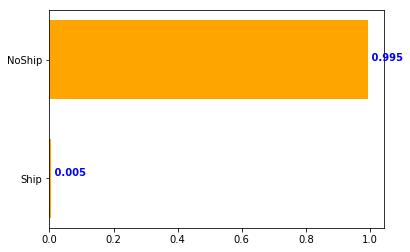

In [11]:
# Define the ratio of ships to noships
ratio = hasship / noship
ratio_ship = round(ratio, 3)
ratio_noship = round(1 - ratio, 3)

# Plot ship/no-ship with a bar plot
fig, ax = plt.subplots()
y = [ratio_ship, ratio_noship]
N = 2
x = ['Ship','NoShip']
width = 1/1.5

plt.barh(x, y, width, align='center', color="orange")
plt.text(ratio_ship, 0.05, " "+str(ratio_ship), color='blue', va='center', fontweight='bold')
plt.text(ratio_noship, 1.02, " "+str(ratio_noship), color='blue', va='center', fontweight='bold')
plt.show()


## 2.4   Quick Analysis and Recommendation

From the provided graphs, the data imbalance is obvious - __70%__ of the pictures do not have ships. One of the serious implication is that the inferred DL model end up being very good at detecting pictures with NO ship. Even in pictures with ships present, most of the pictures (~64%) contains an image with 1 ship. To deal with the imbalance problem, the data generation method is  proposed. It should also be noted that each imageIDs may appear multiple times as it is used to indicate the ship's picture coordinates

### 2.4.1   Determine Number of Valid Images with mask

In [12]:
images_with_ship = masks_data.ImageId[masks_data.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values) 
print('Image files with masks: ' +str(len(images_with_ship)) )

Image files with masks: 29070


### 2.4.2   Image Generation by RandomRotation

33ec2806b.jpg


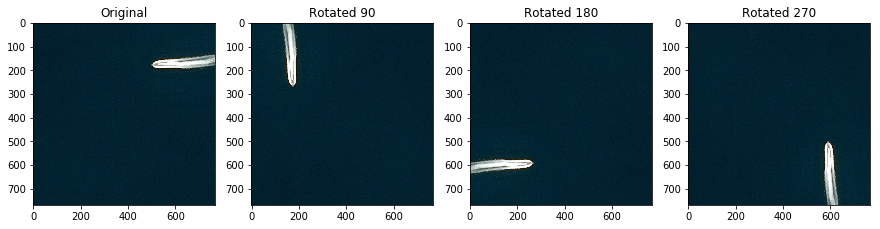

In [13]:
# Load File parameters
# filext = '.jpg'
# testfilename = '6bb3e7515'
# testfile_rotation = train_path + testfilename + filext
rand_image = images_with_ship[random.randint(1, len(images_with_ship))]
testfile_rotation = train_path + rand_image
print(rand_image)

# Load the test file into memory and perform image manipulation
img = Image.open(testfile_rotation)
img_1 = np.array(img)
img_2 = np.array(img.rotate(90))
img_3 = np.array(img.rotate(180))
img_4 = np.array(img.rotate(270))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 10))
ax1.set_title('Original')
ax2.set_title('Rotated 90')
ax3.set_title('Rotated 180')
ax4.set_title('Rotated 270')
ax1.imshow(img_1)
ax2.imshow(img_2)
ax3.imshow(img_3)
ax4.imshow(img_4)

plt.show()

***

# 3.   Visualize Ship Images with Mask Information and Bounding Box

<p style='text-align: justify;'>So what exactly is a mask? 
A Mask refers to the action of taking a copy of the original image, setting some of the image pixel intesity values to a zero or "background" value. As the pixel intesity value is mostly zero in the mask image, then the pixel intensity of the resulting image, can be clearly seen. In our case, we used the EncodedPixel information to visually outline the detected ship, within the masked image. The code segment below will perform just that for 5 images and a side-by-side comparison will be used to illustrate the concept of a mask and how it can be extended to creating a bounding box.</p>

Image 002fdcf51.jpg


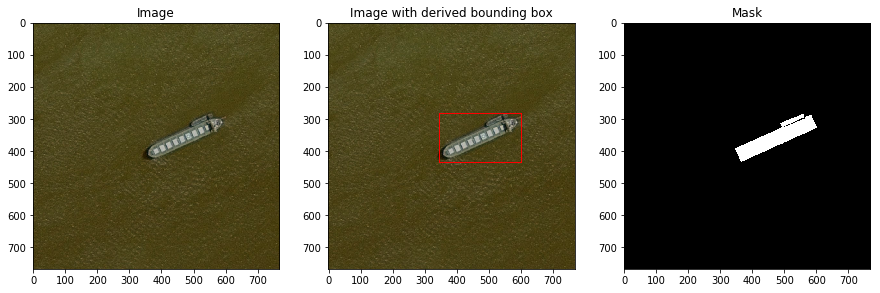

Image 00319c32d.jpg


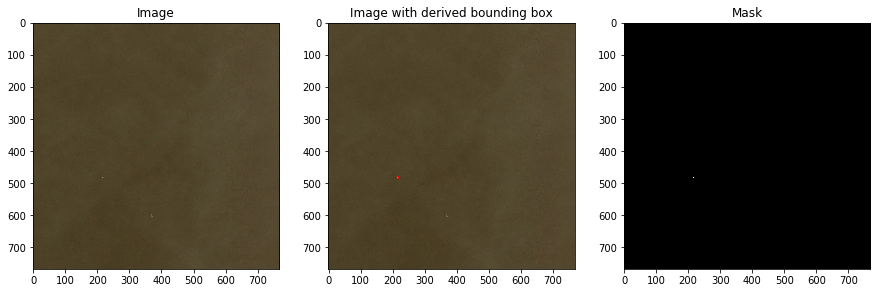

Image 003d43308.jpg


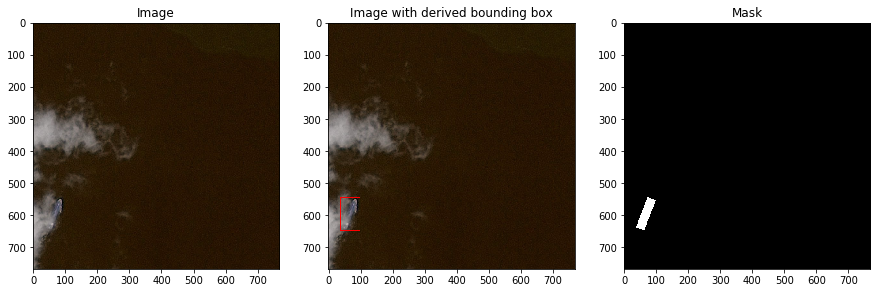

Image 003e2c95d.jpg


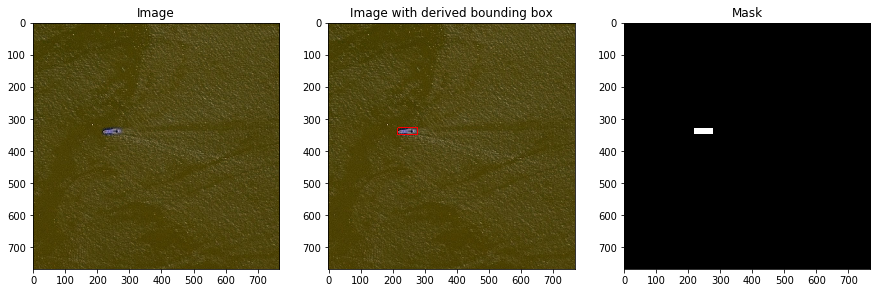

Image 0040cf4e9.jpg


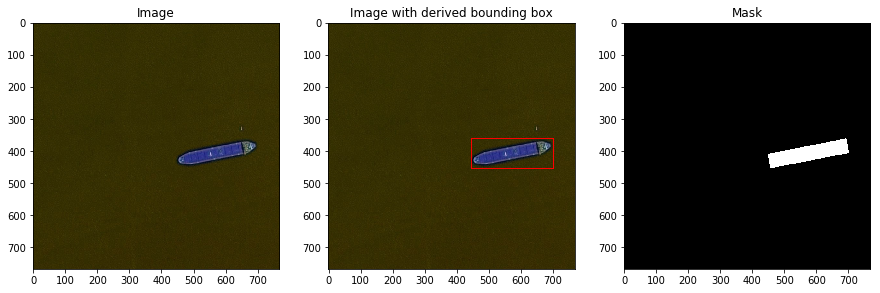

In [14]:
for i in range(5):
    image = images_with_ship[23+i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 15))
    img_0 = cv2.imread(train_path + image)  # translate image into numpy array
    rle_0 = masks_data.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = prelib.masks_as_image(rle_0)

    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)  # Print the ImageID
    for prop in props:
#         print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax3.set_title('Mask')
    ax2.set_title('Image with derived bounding box')
    ax3.imshow(mask_0[...,0], cmap='gray')
    ax2.imshow(img_1)
    plt.show()

***

# 4.   Identify and Export test Parameters for use by Deep Learning Algorithm for Image Segmentation

<p style='text-align: justify;'>As mentioned in our project proposal, we plan to use Faster-RCNN for image segmentation purposes. In addition, a classification algorithm will be used at the intermediate step, to learn the features, before outputting results to the Faster-RCNN model. In order to train the Faster-RCNN model, bounding box and ImageID information is required. In this section, we will briefly touch on the data exporting step.</p>

## 4.1   Create Dictionary of Bounding Boxes w.r.t. Images - for DL algorithm use

<p style='text-align: justify;'>As part of the data preparation process, a dictionary of values (eg. imageID and Bounding Box coordinates) is required to feed and teach the Deep Learning Models during the training phase. In this project, the information will be fed to a VGG16 model followed by Faster-RCNN model for image segmentation purposes. For informational purposes, we have included a progress bar and utilized python's garbage collector to minimize memory hogging. </p>

<p style='text-align: justify;'>*Note: Task Duration is affected by the amount of data, to be processed, and the computing platform that this code is performed on. For example, this task was performed on a hexa-core CPU computing platform and required ~13mins* </p>

In [15]:
if data_generation == True:
    
    bboxes_dict = {}  # Bounding box dictionary
    i = 0
    count_ships = 0
    for image in tqdm(images_with_ship):
        img_0 = cv2.imread(train_path + image)
        rle_0 = masks_data.query('ImageId=="'+image+'"')['EncodedPixels']
        mask_0 = prelib.masks_as_image(rle_0)

        lbl_0 = label(mask_0) 
        props = regionprops(lbl_0)
        bboxes = []
        count_ships = count_ships + len(props)
        for prop in props:
            bboxes.append(prop.bbox)


        i = i + 1
        if i % 400 == 0:
            gc.collect()    

        bboxes_dict[image] = bboxes.copy()

## 4.2   Export the information

In [16]:
if data_generation == True:
    bboxes_df = pd.DataFrame([bboxes_dict])
    bboxes_df = bboxes_df.transpose()
    bboxes_df.columns = ['bbox_list']
    bboxes_df.head()
    
    # Save to csv
    bboxes_df.to_csv('bbox_dictionary.csv')

## 4.3   (Optional) View of Information exported

In [17]:
if data_generation == True:
    # Load the csv file
    read_data = prelib.LoadMyData('bbox_dictionary.csv', pandas=True)
    read_data.head()